In [2]:
# Install PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=53643779e77a4664aa00ba62f3d7016c499c9986ab406bef2822d63645ceaf62
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [3]:
# Import and create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").appName("LA_Analysis").getOrCreate()


In [4]:
pip install geopandas folium


We have installed pyspark

In [5]:
!pip install contextily

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 34.0 MB/s eta 0:00:00


**Loading the Dataset**

In [31]:
import pandas as pd
from pyspark.sql.types import IntegerType, FloatType, DoubleType, StringType
from pyspark.sql.functions import col, sum as _sum, mean, count, max as _max, min, to_timestamp, date_format, lpad, concat, lit, substring, udf, when
from pyspark.sql import SparkSession, Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import Polygon
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from pyspark.sql.functions import col, min, max

In [9]:

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Crime_Data.csv'
la_data = pd.read_csv(file_path)

Mounted at /content/drive


In [10]:
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.show(5)

+---------+--------------------+--------------------+--------+----+---------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+-----------+------+------------+--------+--------+--------+--------+--------------------+------------+-------+---------+
|    DR_NO|           Date Rptd|            DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|         Crm Cd Desc|            Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|         Premis Desc|Weapon Used Cd|Weapon Desc|Status| Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|            LOCATION|Cross Street|    LAT|      LON|
+---------+--------------------+--------------------+--------+----+---------+-----------+--------+------+--------------------+-------------------+--------+--------+------------+---------+--------------------+--------------+-----------+------+------------+--------+--------+--------+--------+--------------------+

In [11]:
column_names = df.columns
column_names

['DR_NO',
 'Date Rptd',
 'DATE OCC',
 'TIME OCC',
 'AREA',
 'AREA NAME',
 'Rpt Dist No',
 'Part 1-2',
 'Crm Cd',
 'Crm Cd Desc',
 'Mocodes',
 'Vict Age',
 'Vict Sex',
 'Vict Descent',
 'Premis Cd',
 'Premis Desc',
 'Weapon Used Cd',
 'Weapon Desc',
 'Status',
 'Status Desc',
 'Crm Cd 1',
 'Crm Cd 2',
 'Crm Cd 3',
 'Crm Cd 4',
 'LOCATION',
 'Cross Street',
 'LAT',
 'LON']

In [12]:
df.count()

892934

In [13]:


df_1 = df

**Data Cleaning**

In [14]:
# Count missing values for each column
missing_values = df_1.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

missing_values.show()

+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|DR_NO|Date Rptd|DATE OCC|TIME OCC|AREA|AREA NAME|Rpt Dist No|Part 1-2|Crm Cd|Crm Cd Desc|Mocodes|Vict Age|Vict Sex|Vict Descent|Premis Cd|Premis Desc|Weapon Used Cd|Weapon Desc|Status|Status Desc|Crm Cd 1|Crm Cd 2|Crm Cd 3|Crm Cd 4|LOCATION|Cross Street|LAT|LON|
+-----+---------+--------+--------+----+---------+-----------+--------+------+-----------+-------+--------+--------+------------+---------+-----------+--------------+-----------+------+-----------+--------+--------+--------+--------+--------+------------+---+---+
|    0|        0|       0|       0|   0|        0|          0|       0|     0|          0| 124329|       0|  118301|      118309|       10|        548|        583395|     583395|     0|          0|      11|  

In [15]:
# Define columns to drop and columns to fill with 'UNKNOWN'
drop_columns = ['DR_NO', 'Rpt Dist No', 'Mocodes', 'Vict Descent', 'Status','Crm Cd 1', 'Crm Cd 2', 'Crm Cd 3', 'Crm Cd 4', 'Cross Street']

df_1 = df_1.drop(*drop_columns)

In [16]:
missing_values = df_1.select([_sum(col(c).isNull().cast("int")).alias(c) for c in df_1.columns])

missing_values.show()

+---------+--------+--------+----+---------+--------+------+-----------+--------+--------+---------+-----------+--------------+-----------+-----------+--------+---+---+
|Date Rptd|DATE OCC|TIME OCC|AREA|AREA NAME|Part 1-2|Crm Cd|Crm Cd Desc|Vict Age|Vict Sex|Premis Cd|Premis Desc|Weapon Used Cd|Weapon Desc|Status Desc|LOCATION|LAT|LON|
+---------+--------+--------+----+---------+--------+------+-----------+--------+--------+---------+-----------+--------------+-----------+-----------+--------+---+---+
|        0|       0|       0|   0|        0|       0|     0|          0|       0|  118301|       10|        548|        583395|     583395|          0|       0|  0|  0|
+---------+--------+--------+----+---------+--------+------+-----------+--------+--------+---------+-----------+--------------+-----------+-----------+--------+---+---+



In [17]:
df_1 = df_1.na.drop(subset=['Premis Cd', 'Premis Desc'])
df_1


DataFrame[Date Rptd: string, DATE OCC: string, TIME OCC: int, AREA: int, AREA NAME: string, Part 1-2: int, Crm Cd: int, Crm Cd Desc: string, Vict Age: int, Vict Sex: string, Premis Cd: int, Premis Desc: string, Weapon Used Cd: int, Weapon Desc: string, Status Desc: string, LOCATION: string, LAT: double, LON: double]

In [18]:
numerical_cols = [field.name for field in df_1.schema.fields if isinstance(field.dataType, (IntegerType, FloatType, DoubleType))]
categorical_cols = [field.name for field in df_1.schema.fields if isinstance(field.dataType, StringType)]


In [19]:
# Calculate mean for numerical columns and fill nulls
for col_name in numerical_cols:
    mean_value = df_1.select(mean(col(col_name)).alias('mean')).collect()[0]['mean']
    df_1 = df_1.na.fill({col_name: mean_value})


In [20]:
# Calculate mode for each categorical column and fill nulls
for col_name in categorical_cols:
    mode_value = df_1.filter(df[col_name].isNotNull()) \
                   .groupBy(col_name) \
                   .count() \
                   .orderBy('count', ascending=False) \
                   .limit(1) \
                   .collect()

    # Fill with mode if found; otherwise, use a default value
    if mode_value:
        mode_value = mode_value[0][0]
        df_1 = df_1.na.fill({col_name: mode_value})
    else:
        # Specify a default value for each categorical column as necessary
        default_value = "Unknown"
        df_1 = df_1.na.fill({col_name: default_value})

In [21]:
df_1.show()

+--------------------+--------------------+--------+----+-----------+--------+------+--------------------+--------+--------+---------+--------------------+--------------+--------------------+------------+--------------------+-------+---------+
|           Date Rptd|            DATE OCC|TIME OCC|AREA|  AREA NAME|Part 1-2|Crm Cd|         Crm Cd Desc|Vict Age|Vict Sex|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc| Status Desc|            LOCATION|    LAT|      LON|
+--------------------+--------------------+--------+----+-----------+--------+------+--------------------+--------+--------+---------+--------------------+--------------+--------------------+------------+--------------------+-------+---------+
|03/01/2020 12:00:...|03/01/2020 12:00:...|    2130|   7|   Wilshire|       1|   510|    VEHICLE - STOLEN|       0|       M|      101|              STREET|           363|STRONG-ARM (HANDS...|Adult Arrest|1900 S  LONGWOOD ...|34.0375|-118.3506|
|02/09/2020 12:00:...|02

In [22]:
# Calculate value counts for 'Crm Cd Desc'
crm_cd_desc_counts_df = df_1.groupBy("Crm Cd Desc") \
    .count() \
    .withColumnRenamed("count", "Count") \
    .withColumnRenamed("Crm Cd Desc", "Crm Cd Desc") \
    .sort(col("Count").desc())
crm_cd_desc_counts_df.show(crm_cd_desc_counts_df.count(), truncate=False)


+--------------------------------------------------------+-----+
|Crm Cd Desc                                             |Count|
+--------------------------------------------------------+-----+
|VEHICLE - STOLEN                                        |95864|
|BATTERY - SIMPLE ASSAULT                                |71002|
|THEFT OF IDENTITY                                       |55350|
|BURGLARY FROM VEHICLE                                   |55116|
|BURGLARY                                                |54381|
|VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) |54134|
|ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT          |50879|
|THEFT PLAIN - PETTY ($950 & UNDER)                      |45541|
|INTIMATE PARTNER - SIMPLE ASSAULT                       |44531|
|THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)         |34304|
|THEFT FROM MOTOR VEHICLE - GRAND ($950.01 AND OVER)     |31950|
|ROBBERY                                                 |30486|
|THEFT-GRAND ($950.01 & O

In [23]:
# Count occurrences of each unique value in 'Weapon Desc' column
weapon_used_counts = df_1.groupBy("Weapon Desc").count()
weapon_used_counts_df = weapon_used_counts.withColumnRenamed("Weapon Desc", "Weapon Used Cd").withColumnRenamed("count", "Count")
weapon_used_counts_df.show(weapon_used_counts_df.count(), truncate=False)

+----------------------------------------------+------+
|Weapon Used Cd                                |Count |
+----------------------------------------------+------+
|BELT FLAILING INSTRUMENT/CHAIN                |647   |
|BLACKJACK                                     |12    |
|SEMI-AUTOMATIC PISTOL                         |6916  |
|OTHER FIREARM                                 |889   |
|OTHER KNIFE                                   |5588  |
|BOTTLE                                        |2294  |
|UNK TYPE SEMIAUTOMATIC ASSAULT RIFLE          |14    |
|SWITCH BLADE                                  |221   |
|BOWIE KNIFE                                   |32    |
|SAWED OFF RIFLE/SHOTGUN                       |27    |
|AIR PISTOL/REVOLVER/RIFLE/BB GUN              |1767  |
|OTHER CUTTING INSTRUMENT                      |876   |
|ASSAULT WEAPON/UZI/AK47/ETC                   |74    |
|UNKNOWN FIREARM                               |6246  |
|AUTOMATIC WEAPON/SUB-MACHINE GUN              |

In [24]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [25]:
# Convert 'Date Rptd' and 'DATE OCC' to datetime and then back to string in 'MM-dd-yyyy' format
df_1 = df_1.withColumn('Date Rptd', date_format(to_timestamp('Date Rptd', 'MM/dd/yyyy'), 'MM-dd-yyyy')) \
           .withColumn('DATE OCC', date_format(to_timestamp('DATE OCC', 'MM/dd/yyyy'), 'MM-dd-yyyy'))

# Ensure 'TIME OCC' is a 4-character string, extract hour and minute, set minutes to '00'
df_1 = df_1.withColumn('TIME OCC', lpad(df_1['TIME OCC'], 4, '0')) \
           .withColumn('Hour', substring('TIME OCC', 1, 2)) \
           .withColumn('Minute', lit('00'))

df_1 = df_1.withColumn('TIME OCC', concat(df_1['Hour'], lit(':'), df_1['Minute']))
df_1.show()

+----------+----------+--------+----+-----------+--------+------+--------------------+--------+--------+---------+--------------------+--------------+--------------------+------------+--------------------+-------+---------+----+------+
| Date Rptd|  DATE OCC|TIME OCC|AREA|  AREA NAME|Part 1-2|Crm Cd|         Crm Cd Desc|Vict Age|Vict Sex|Premis Cd|         Premis Desc|Weapon Used Cd|         Weapon Desc| Status Desc|            LOCATION|    LAT|      LON|Hour|Minute|
+----------+----------+--------+----+-----------+--------+------+--------------------+--------+--------+---------+--------------------+--------------+--------------------+------------+--------------------+-------+---------+----+------+
|03-01-2020|03-01-2020|   21:00|   7|   Wilshire|       1|   510|    VEHICLE - STOLEN|       0|       M|      101|              STREET|           363|STRONG-ARM (HANDS...|Adult Arrest|1900 S  LONGWOOD ...|34.0375|-118.3506|  21|    00|
|02-09-2020|02-08-2020|   18:00|   1|    Central|       

In [26]:
df_1 = df_1.na.drop(subset=['DATE Rptd'])

In [30]:
date_range = df_1.agg(min(col('DATE OCC')), max(col('DATE OCC'))).collect()
start_date = date_range[0][0]
end_date = date_range[0][1]

print("Time Range Covered by the Dataset:")
print("Start Date:", start_date)
print("End Date:", end_date)


Time Range Covered by the Dataset:
Start Date: 01-01-2020
End Date: 12-31-2023


In [32]:
drop_columns = ['Date Rptd', 'TIME OCC', 'AREA',  'Part 1-2','Crm Cd', 'Premis Cd', 'Status Desc', 'LOCATION','Weapon Used Cd']
df_1 = df_1.drop(*drop_columns)

In [33]:
df_1.show()

+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+
|  DATE OCC|  AREA NAME|         Crm Cd Desc|Vict Age|Vict Sex|         Premis Desc|         Weapon Desc|    LAT|      LON|Hour|Minute|
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+
|03-01-2020|   Wilshire|    VEHICLE - STOLEN|       0|       M|              STREET|STRONG-ARM (HANDS...|34.0375|-118.3506|  21|    00|
|02-08-2020|    Central|BURGLARY FROM VEH...|      47|       M|BUS STOP/LAYOVER ...|STRONG-ARM (HANDS...|34.0444|-118.2628|  18|    00|
|11-04-2020|  Southwest|       BIKE - STOLEN|      19|       X|MULTI-UNIT DWELLI...|STRONG-ARM (HANDS...| 34.021|-118.3002|  17|    00|
|03-10-2020|   Van Nuys|SHOPLIFTING-GRAND...|      19|       M|      CLOTHING STORE|STRONG-ARM (HANDS...|34.1576|-118.4387|  20|    00|
|08-17-2020|  Hollywood|   THEFT OF IDENTITY|   

In [34]:
df_2=df_1

In [35]:
# Define crime categories and severity scores as Spark DataFrames
crime_categories = {
    'Violent Crimes': ['HOMICIDE', 'RAPE', 'ROBBERY', 'KIDNAPPING', 'ASSAULT WITH DEADLY WEAPON', 'BATTERY - SIMPLE ASSAULT', 'AGGRAVATED ASSAULT', 'INTIMATE PARTNER', 'CRIMINAL THREATS', 'BRANDISH WEAPON', 'SEXUAL PENETRATION', 'CHILD ABUSE', 'DISCHARGE FIREARMS', 'SHOTS FIRED', 'CRIMINAL HOMICIDE', 'ORAL COPULATION', 'LEWD CONDUCT', 'SODOMY', 'RAPE, ATTEMPTED', 'CHILD STEALING', 'KIDNAPPING - GRAND ATTEMPT', 'BATTERY WITH SEXUAL CONTACT', 'ASSAULT WITH DEADLY WEAPON ON POLICE OFFICER', 'SEXUAL ASSAULT', 'BEASTIALITY', 'LYNCHING', 'LYNCHING - ATTEMPTED', 'RESISTING ARREST', 'BATTERY POLICE (SIMPLE)'],
    'Property Crimes': ['BURGLARY', 'VEHICLE - STOLEN', 'THEFT', 'ARSON', 'VANDALISM', 'BURGLARY FROM VEHICLE', 'THEFT FROM MOTOR VEHICLE', 'SHOPLIFTING', 'BUNCO', 'EMBEZZLEMENT', 'FORGERY', 'EXTORTION', 'COUNTERFEIT', 'GRAND THEFT', 'TILL TAP', 'THEFT, COIN MACHINE', 'PICKPOCKET', 'DEFRAUDING INNKEEPER', 'BUNCO, ATTEMPT', 'BIKE - STOLEN','BIKE - ATTEMPTED STOLEN', 'VEHICLE - ATTEMPT STOLEN', 'VEHICLE, STOLEN - OTHER (MOTORIZED SCOOTERS, BIKES, ETC)', 'BOAT - STOLEN', 'TELEPHONE PROPERTY - DAMAGE'],
    'Drug/Alcohol Related': ['DRUNK ROLL', 'DRUGS, TO A MINOR'],
    'Sex Crimes': ['SEX,UNLAWFUL(INC MUTUAL CONSENT, PENETRATION W/ FRGN OBJ', 'INDECENT EXPOSURE', 'PEEPING TOM', 'CHILD PORNOGRAPHY', 'CHILD MOLEST', 'SEX OFFENDER REGISTRANT OUT OF COMPLIANCE','LEWD/LASCIVIOUS ACTS WITH CHILD', 'STALKING'],
    'Theft/Fraud': ['PURSE SNATCHING', 'PURSE SNATCHING - ATTEMPT', 'THEFT OF IDENTITY', 'CREDIT CARDS, FRAUD USE', 'UNAUTHORIZED COMPUTER ACCESS', 'DOCUMENT FORGERY', 'DOCUMENT WORTHLESS', 'CONTEMPT OF COURT', 'VIOLATION OF COURT ORDER', 'VIOLATION OF RESTRAINING ORDER', 'VIOLATION OF TEMPORARY RESTRAINING ORDER', 'FAILURE TO YIELD', 'FAILURE TO DISPERSE', 'FALSE POLICE REPORT', 'FALSE IMPRISONMENT', 'ILLEGAL DUMPING', 'TRAIN WRECKING'],
    'Traffic Violations': ['FAILURE TO YIELD', 'RECKLESS DRIVING', 'DRIVING WITHOUT OWNER CONSENT (DWOC)'],
    'Weapons Violation': ['BRANDISH WEAPON', 'WEAPONS POSSESSION'],
    'Non-Violent Miscellaneous': ['TRESPASSING', 'DISORDERLY CONDUCT', 'DISTURBING THE PEACE', 'OTHER MISCELLANEOUS CRIME', 'CONSPIRACY', 'INCITING A RIOT', 'CHILD ABANDONMENT', 'BIGAMY', 'BRIBERY', 'CONTRIBUTING', 'LETTERS, LEWD  -  TELEPHONE CALLS, LEWD', 'THREATENING PHONE CALLS/LETTERS', 'PROWLER', 'INCEST (SEXUAL ACTS BETWEEN BLOOD RELATIVES)', 'FIREARMS RESTRAINING ORDER (FIREARMS RO)', 'DISRUPT SCHOOL', 'REPLICA FIREARMS(SALE,DISPLAY,MANUFACTURE OR DISTRIBUTE)', 'BLOCKING DOOR INDUCTION CENTER', 'FIREARMS EMERGENCY PROTECTIVE ORDER (FIREARMS EPO)', 'OTHER ASSAULT'],
    'Domestic Violence': ['INTIMATE PARTNER - SIMPLE ASSAULT', 'INTIMATE PARTNER - AGGRAVATED ASSAULT', 'VIOLATION OF RESTRAINING ORDER', 'CRM AGNST CHLD (13 OR UNDER) (14-15 & SUSP 10 YRS OLDER)', 'CHILD NEGLECT', 'CHILD ANNOYING', 'CHILD ABUSE', 'DOMESTIC VIOLENCE'],
    'Serious Violations': ['ASSAULT ON POLICE OFFICER', 'KIDNAPPING', 'THROWING OBJECT AT MOVING VEHICLE', 'BOMB SCARE', 'HUMAN TRAFFICKING', 'KIDNAPPING - GRAND ATTEMPT', 'PANDERING', 'PIMPING', 'CRUELTY TO ANIMALS', 'HOMICIDE','MANSLAUGHTER, NEGLIGENT' , 'BATTERY ON A FIREFIGHTER']
}

default_category = 'Other'

severity_scores = {
    'Violent Crimes': 10,
    'Property Crimes': 7,
    'Drug/Alcohol Related': 5,
    'Sex Crimes': 9,
    'Theft/Fraud': 6,
    'Traffic Violations': 4,
    'Weapons Violation': 8,
    'Non-Violent Miscellaneous': 3,
    'Domestic Violence': 7,
    'Serious Violations': 9
}

# Define UDF for categorizing crime description
def categorize_crime_description(crime_desc):
    for category, keywords in crime_categories.items():
        if any(keyword in crime_desc.upper() for keyword in keywords):
            return category
    return default_category
categorize_crime_description_udf = udf(categorize_crime_description, StringType())

df_2 = df_2.withColumn('Crime Description', categorize_crime_description_udf(df_2['Crm Cd Desc']))

# Map severity scores based on crime description
severity_udf = udf(lambda x: severity_scores.get(x, 0), IntegerType())
df_2 = df_2.withColumn('Severity_Crime', severity_udf(df_2['Crime Description']))

df_2.show()


+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+
|  DATE OCC|  AREA NAME|         Crm Cd Desc|Vict Age|Vict Sex|         Premis Desc|         Weapon Desc|    LAT|      LON|Hour|Minute|Crime Description|Severity_Crime|
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+
|03-01-2020|   Wilshire|    VEHICLE - STOLEN|       0|       M|              STREET|STRONG-ARM (HANDS...|34.0375|-118.3506|  21|    00|  Property Crimes|             7|
|02-08-2020|    Central|BURGLARY FROM VEH...|      47|       M|BUS STOP/LAYOVER ...|STRONG-ARM (HANDS...|34.0444|-118.2628|  18|    00|  Property Crimes|             7|
|11-04-2020|  Southwest|       BIKE - STOLEN|      19|       X|MULTI-UNIT DWELLI...|STRONG-ARM (HANDS...| 34.021|-118.3002|  17|    00|  Property Crimes|  

In [36]:
assembler = VectorAssembler(inputCols=["LAT", "LON"], outputCol="features")
df_2 = assembler.transform(df_2)

In [37]:
# Fit KMeans model
kmeans = KMeans(k=5, seed=0, featuresCol="features", predictionCol="Cluster")
model = kmeans.fit(df_2)

# Add cluster labels to the DataFrame
df_2 = model.transform(df_2)

# Create a mapping from cluster labels to zones
zone_mapping = {0: 'zone1', 1: 'zone2', 2: 'zone3', 3: 'zone4', 4: 'zone5'}

def map_cluster_to_zone(cluster):
    return zone_mapping.get(cluster, "Unknown")

map_cluster_to_zone_udf = udf(map_cluster_to_zone, StringType())

# Add a new column "Zone" with zone names
df_2 = df_2.withColumn("Zone", map_cluster_to_zone_udf(df_2["Cluster"]))
df_2.show()

+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+-------------------+-------+-----+
|  DATE OCC|  AREA NAME|         Crm Cd Desc|Vict Age|Vict Sex|         Premis Desc|         Weapon Desc|    LAT|      LON|Hour|Minute|Crime Description|Severity_Crime|           features|Cluster| Zone|
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+-------------------+-------+-----+
|03-01-2020|   Wilshire|    VEHICLE - STOLEN|       0|       M|              STREET|STRONG-ARM (HANDS...|34.0375|-118.3506|  21|    00|  Property Crimes|             7|[34.0375,-118.3506]|      4|zone5|
|02-08-2020|    Central|BURGLARY FROM VEH...|      47|       M|BUS STOP/LAYOVER ...|STRONG-ARM (HANDS...|34.0444|-118.2628|  18|    00|  Property Crimes|             7|[34.0444,-118.2628]|

In [38]:
# Filter rows where Zone is "zone1"
zone1_data = df_2.filter(df_2["Zone"] == "zone1")
zone1_data.show()

+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+-------------------+-------+-----+
|  DATE OCC|  AREA NAME|         Crm Cd Desc|Vict Age|Vict Sex|         Premis Desc|         Weapon Desc|    LAT|      LON|Hour|Minute|Crime Description|Severity_Crime|           features|Cluster| Zone|
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+-------+---------+----+------+-----------------+--------------+-------------------+-------+-----+
|03-10-2020|   Van Nuys|SHOPLIFTING-GRAND...|      19|       M|      CLOTHING STORE|STRONG-ARM (HANDS...|34.1576|-118.4387|  20|    00|  Property Crimes|             7|[34.1576,-118.4387]|      0|zone1|
|12-31-2020|    Mission|BATTERY - SIMPLE ...|      26|       M|MULTI-UNIT DWELLI...|STRONG-ARM (HANDS...|34.2336|-118.4535|  12|    00|   Violent Crimes|            10|[34.2336,-118.4535]|

In [39]:
zone2_data = df_2.filter(df_2["Zone"] == "zone2")
zone3_data = df_2.filter(df_2["Zone"] == "zone3")
zone4_data = df_2.filter(df_2["Zone"] == "zone4")
zone5_data = df_2.filter(df_2["Zone"] == "zone5")

In [40]:
print(zone1_data.count())
print(zone2_data.count())
print(zone3_data.count())
print(zone4_data.count())
print(zone5_data.count())

155844
2263
407079
101369
225831


In [41]:
zone2_data = df_2.filter(df_2["Zone"] == "zone2")
zone3_data = df_2.filter(df_2["Zone"] == "zone3")
zone4_data = df_2.filter(df_2["Zone"] == "zone4")
zone5_data = df_2.filter(df_2["Zone"] == "zone5")

print("Zone 2 data:")
zone2_data.show()

print("Zone 3 data:")
zone3_data.show()

print("Zone 4 data:")
zone4_data.show()

print("Zone 5 data:")
zone5_data.show()


Zone 2 data:
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+---+---+----+------+--------------------+--------------+---------+-------+-----+
|  DATE OCC|  AREA NAME|         Crm Cd Desc|Vict Age|Vict Sex|         Premis Desc|         Weapon Desc|LAT|LON|Hour|Minute|   Crime Description|Severity_Crime| features|Cluster| Zone|
+----------+-----------+--------------------+--------+--------+--------------------+--------------------+---+---+----+------+--------------------+--------------+---------+-------+-----+
|06-12-2020|    Pacific|   THEFT OF IDENTITY|      30|       F|SINGLE FAMILY DWE...|STRONG-ARM (HANDS...|0.0|0.0|  09|    00|     Property Crimes|             7|(2,[],[])|      1|zone2|
|12-17-2020| Hollenbeck|VIOLATION OF COUR...|      65|       M|     OTHER RESIDENCE|STRONG-ARM (HANDS...|0.0|0.0|  15|    00|         Theft/Fraud|             6|(2,[],[])|      1|zone2|
|11-20-2020|N Hollywood|               ARSON|       0|   

In [42]:
highest_latitude = df_2.agg(F.max("LAT")).collect()[0][0]
lowest_longitude = df_2.agg(F.min("LON")).collect()[0][0]

print("Highest Latitude:", highest_latitude)
print("Lowest Longitude:", lowest_longitude)


Highest Latitude: 34.3343
Lowest Longitude: -118.6676


In [43]:
pandas_df = df_2.toPandas()


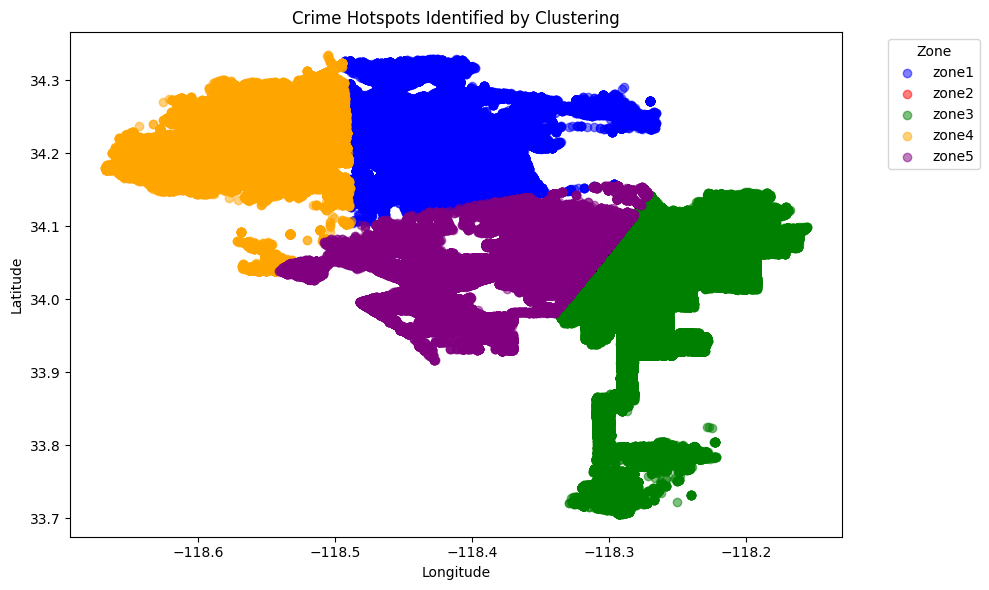

In [44]:

plt.figure(figsize=(10, 6))
min_lat = 33.0
max_lat = 34.3343
min_lon = -118.6676
max_lon = 118.0
filtered_df = pandas_df[(pandas_df['LAT'] >= min_lat) & (pandas_df['LAT'] <= max_lat) &
                        (pandas_df['LON'] >= min_lon) & (pandas_df['LON'] <= max_lon)]

colors = ['blue', 'red', 'green', 'orange', 'purple']
for cluster_number, color in zip(zone_mapping.keys(), colors):
    cluster_data = filtered_df[filtered_df['Cluster'] == cluster_number]
    plt.scatter(cluster_data['LON'], cluster_data['LAT'], c=color, label=zone_mapping[cluster_number], alpha=0.5)

plt.title('Crime Hotspots Identified by Clustering')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Zone', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [45]:
zone5_data_selected = zone5_data.select("DATE OCC", "Vict Age", "Zone")
df_2_with_zone5 = df_2.join(zone5_data_selected, (df_2["DATE OCC"] == zone5_data_selected["DATE OCC"]) & (df_2["Vict Age"] == zone5_data_selected["Vict Age"]), "left")
df_2_with_zone5 = df_2_with_zone5.drop(zone5_data_selected["DATE OCC"]).drop(zone5_data_selected["Vict Age"])


In [46]:
drop_columns = ['Crm Cd Desc','Premis Desc','Minute','features','Cluster']
df_2 = df_2.drop(*drop_columns)
df_2.show()

+----------+-----------+--------+--------+--------------------+-------+---------+----+-----------------+--------------+-----+
|  DATE OCC|  AREA NAME|Vict Age|Vict Sex|         Weapon Desc|    LAT|      LON|Hour|Crime Description|Severity_Crime| Zone|
+----------+-----------+--------+--------+--------------------+-------+---------+----+-----------------+--------------+-----+
|03-01-2020|   Wilshire|       0|       M|STRONG-ARM (HANDS...|34.0375|-118.3506|  21|  Property Crimes|             7|zone5|
|02-08-2020|    Central|      47|       M|STRONG-ARM (HANDS...|34.0444|-118.2628|  18|  Property Crimes|             7|zone3|
|11-04-2020|  Southwest|      19|       X|STRONG-ARM (HANDS...| 34.021|-118.3002|  17|  Property Crimes|             7|zone3|
|03-10-2020|   Van Nuys|      19|       M|STRONG-ARM (HANDS...|34.1576|-118.4387|  20|  Property Crimes|             7|zone1|
|08-17-2020|  Hollywood|      28|       M|STRONG-ARM (HANDS...|34.0944|-118.3277|  12|  Property Crimes|             7

In [47]:
df_2 = df_2.withColumn("Hour", col("Hour").cast("int"))

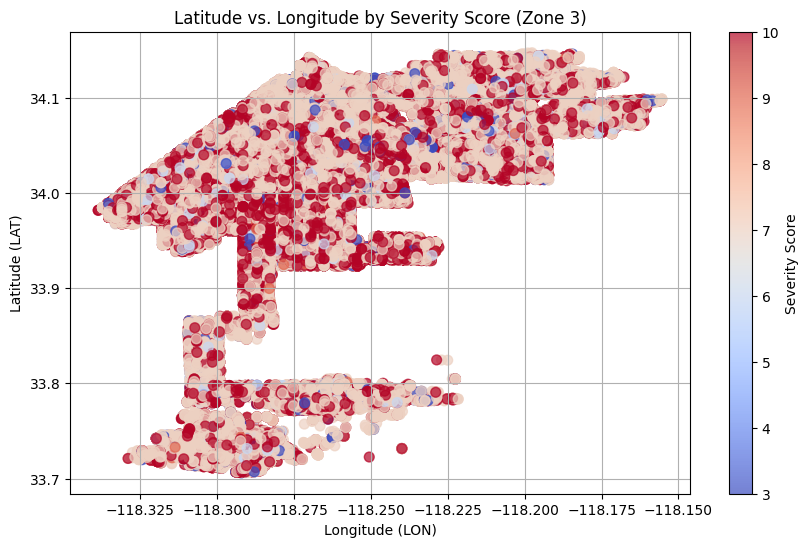

In [48]:
df_zone3 = df_2.filter(df_2["Zone"] == "zone3")

df_zone3 = df_zone3.withColumn("LON", df_zone3["LON"].cast("double"))
df_zone3 = df_zone3.withColumn("LAT", df_zone3["LAT"].cast("double"))
df_zone3 = df_zone3.withColumn("Severity_Crime", df_zone3["Severity_Crime"].cast("double"))
df_zone3 = df_zone3.dropna(subset=["LON", "LAT", "Severity_Crime"])

plt.figure(figsize=(10, 6))
plt.scatter(df_zone3.select("LON").collect(), df_zone3.select("LAT").collect(),
            c=df_zone3.select("Severity_Crime").collect(), cmap="coolwarm", s=50, alpha=0.7)
plt.colorbar(label="Severity Score")
plt.xlabel("Longitude (LON)")
plt.ylabel("Latitude (LAT)")
plt.title("Latitude vs. Longitude by Severity Score (Zone 3)")
plt.grid(True)
plt.show()

**Data Visualization** -
on df_zone3 df

This bar chart illustrates the top 10 crimes in LA

Insight: This visualization will show which types of crimes are most common, providing a focus area for crime prevention efforts.


In [49]:
df_zone3.show()

+----------+-----------+--------+--------+--------------------+-------+---------+----+-----------------+--------------+-----+
|  DATE OCC|  AREA NAME|Vict Age|Vict Sex|         Weapon Desc|    LAT|      LON|Hour|Crime Description|Severity_Crime| Zone|
+----------+-----------+--------+--------+--------------------+-------+---------+----+-----------------+--------------+-----+
|02-08-2020|    Central|      47|       M|STRONG-ARM (HANDS...|34.0444|-118.2628|  18|  Property Crimes|           7.0|zone3|
|11-04-2020|  Southwest|      19|       X|STRONG-ARM (HANDS...| 34.021|-118.3002|  17|  Property Crimes|           7.0|zone3|
|12-01-2020|  Southeast|      41|       M|STRONG-ARM (HANDS...|33.9467|-118.2463|  23|  Property Crimes|           7.0|zone3|
|07-03-2020|    Central|      25|       M|STRONG-ARM (HANDS...|34.0415| -118.262|   9|  Property Crimes|           7.0|zone3|
|12-09-2020|     Newton|      24|       F|STRONG-ARM (HANDS...|33.9911|-118.2521|  14|  Property Crimes|           7.0

In [50]:
pandas_df_2 = df_zone3.toPandas()

<ipython-input-51-7f0178b8a9b8>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=crime_counts_df.head(top_n), x='Total', y='Crime Description', palette='viridis')


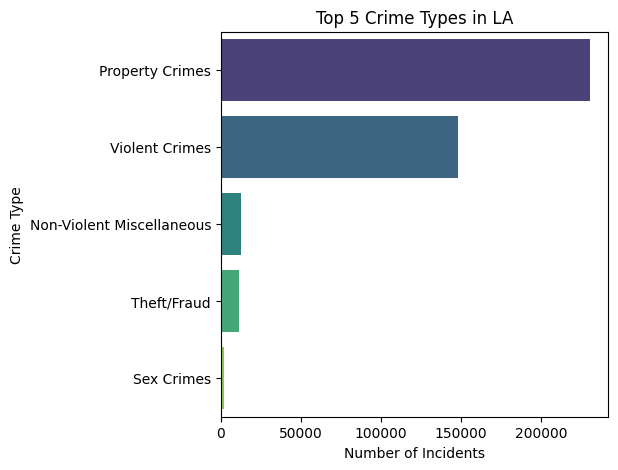

In [51]:
crime_counts_df = pandas_df_2.groupby("Crime Description").size().reset_index(name='Total').sort_values(by='Total', ascending=False)
top_n = 5
plt.figure(figsize=(5, 5))
sns.barplot(data=crime_counts_df.head(top_n), x='Total', y='Crime Description', palette='viridis')
plt.title('Top 5 Crime Types in LA')
plt.xlabel('Number of Incidents')
plt.ylabel('Crime Type')
plt.show()

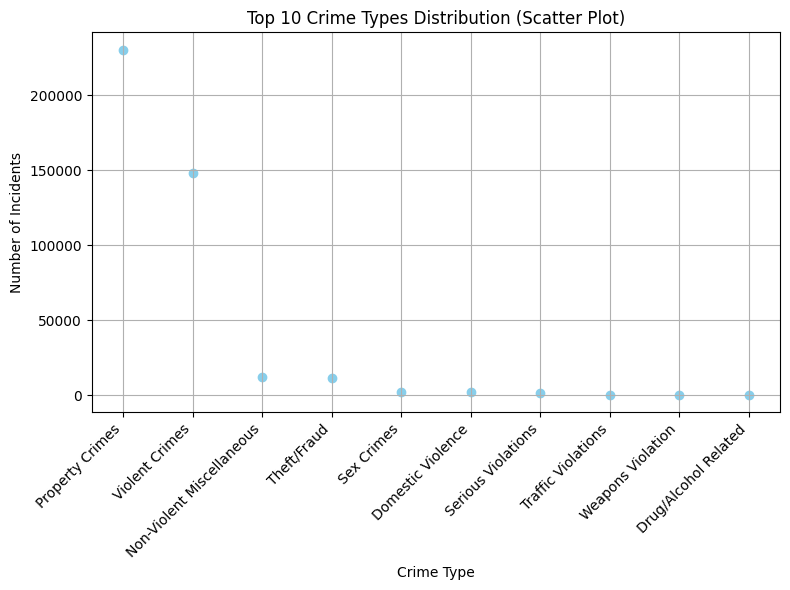

In [52]:
plt.figure(figsize=(8, 6))
plt.scatter(crime_counts_df['Crime Description'], crime_counts_df['Total'], color='skyblue')
plt.title('Top 10 Crime Types Distribution (Scatter Plot)')
plt.xlabel('Crime Type')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45, ha="right")
plt.grid(True)
plt.tight_layout()
plt.show()


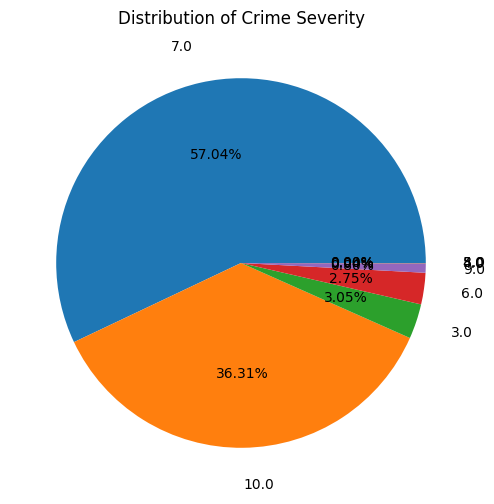

In [53]:
plt.figure(figsize=(8, 6))
pandas_df_2['Severity_Crime'].value_counts().plot(kind='pie', autopct='%1.2f%%',labeldistance=1.20)
plt.title('Distribution of Crime Severity')
plt.ylabel('')
plt.show()

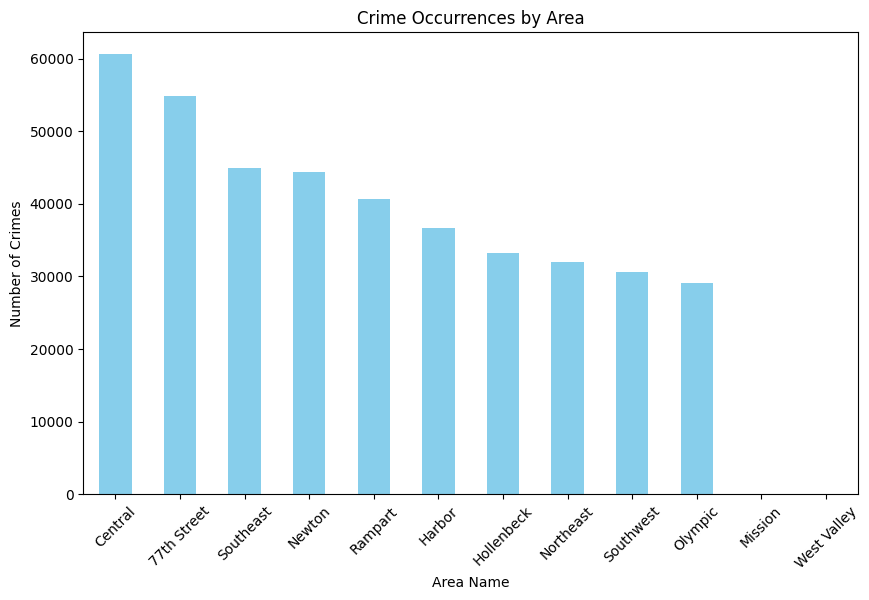

In [54]:
plt.figure(figsize=(10, 6))
pandas_df_2['AREA NAME'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Crime Occurrences by Area')
plt.xlabel('Area Name')
plt.ylabel('Number of Crimes')
plt.xticks(rotation=45)
plt.show()

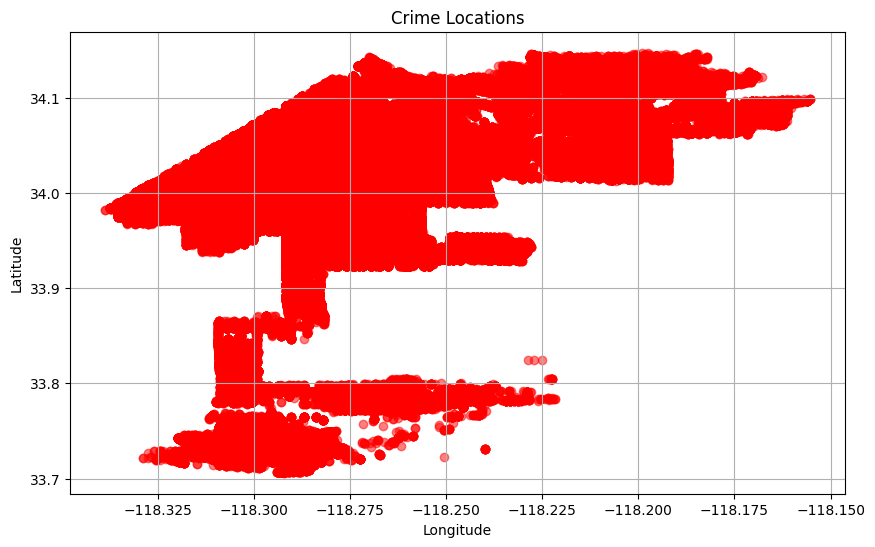

In [55]:
plt.figure(figsize=(10, 6))
plt.scatter(pandas_df_2['LON'], pandas_df_2['LAT'], alpha=0.5, c='red')
plt.title('Crime Locations')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [56]:
sampled_data = df_zone3.sample(withReplacement=False, fraction=0.1)
sampled_data = sampled_data.toPandas()
sampled_data['LAT'] = pd.to_numeric(sampled_data['LAT'], errors='coerce')
sampled_data['LON'] = pd.to_numeric(sampled_data['LON'], errors='coerce')
sampled_data.dropna(subset=['LAT', 'LON'], inplace=True)
map_la = folium.Map(location=[sampled_data['LAT'].mean(), sampled_data['LON'].mean()], zoom_start=11)
HeatMap(data=sampled_data[['LAT', 'LON']].values, radius=10).add_to(map_la)

map_la

In [57]:
future_data = df_2.toPandas()

In [58]:
la_df = df_2.toPandas()

In [59]:
features = ['Vict Age', 'Vict Sex', 'Weapon Desc', 'LAT', 'LON', 'Hour', 'Crime Description']
target = 'Severity_Crime'

target_encoder = LabelEncoder()
categorical_cols = ['Vict Sex', 'Weapon Desc', 'Crime Description']

# We create a separate encoder for categorical features to prevent any mix-up with the target encoder
feature_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    la_df[col] = le.fit_transform(la_df[col])
    feature_encoders[col] = le

# Encode the target column
y_encoded = target_encoder.fit_transform(la_df[target])
X = la_df[features]
y = y_encoded

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [60]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)
y_pred_log_reg = log_reg.predict(X_test)

print("\nLogistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.89      0.88      0.88     10099
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00        18
           3       0.96      0.98      0.97      7042
           4       0.99      0.99      0.99    166807
           5       0.00      0.00      0.00         9
           6       0.96      0.70      0.81      2001
           7       1.00      1.00      1.00     81623

    accuracy                           0.99    267716
   macro avg       0.60      0.57      0.58    267716
weighted avg       0.99      0.99      0.99    267716

Accuracy: 0.9869040326315947


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
y_pred_dec_tree = decision_tree.predict(X_test)

print("\nDecision Tree Classification Report:")
print(classification_report(y_test, y_pred_dec_tree))
print("Accuracy:", accuracy_score(y_test, y_pred_dec_tree))



Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10099
           1       1.00      1.00      1.00       117
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00      7042
           4       1.00      1.00      1.00    166807
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00      2001
           7       1.00      1.00      1.00     81623

    accuracy                           1.00    267716
   macro avg       1.00      1.00      1.00    267716
weighted avg       1.00      1.00      1.00    267716

Accuracy: 1.0


In [62]:
random_forest = RandomForestClassifier(max_depth=2, n_estimators=50)
random_forest.fit(X_train, y_train)
y_pred_rand_forest = random_forest.predict(X_test)

print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rand_forest))
print("Accuracy:", accuracy_score(y_test, y_pred_rand_forest))



Random Forest Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10099
           1       0.00      0.00      0.00       117
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00      7042
           4       0.89      1.00      0.94    166807
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00      2001
           7       1.00      0.99      1.00     81623

    accuracy                           0.93    267716
   macro avg       0.24      0.25      0.24    267716
weighted avg       0.86      0.93      0.89    267716

Accuracy: 0.9257459397271736


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [63]:
gradient_boosting = GradientBoostingClassifier()
gradient_boosting.fit(X_train, y_train)
y_pred_grad_boost = gradient_boosting.predict(X_test)

print("\nGradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_grad_boost))
print("Accuracy:", accuracy_score(y_test, y_pred_grad_boost))



Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10099
           1       1.00      1.00      1.00       117
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00      7042
           4       1.00      1.00      1.00    166807
           5       1.00      1.00      1.00         9
           6       1.00      1.00      1.00      2001
           7       1.00      1.00      1.00     81623

    accuracy                           1.00    267716
   macro avg       1.00      1.00      1.00    267716
weighted avg       1.00      1.00      1.00    267716

Accuracy: 1.0


**Time Series Analysis**

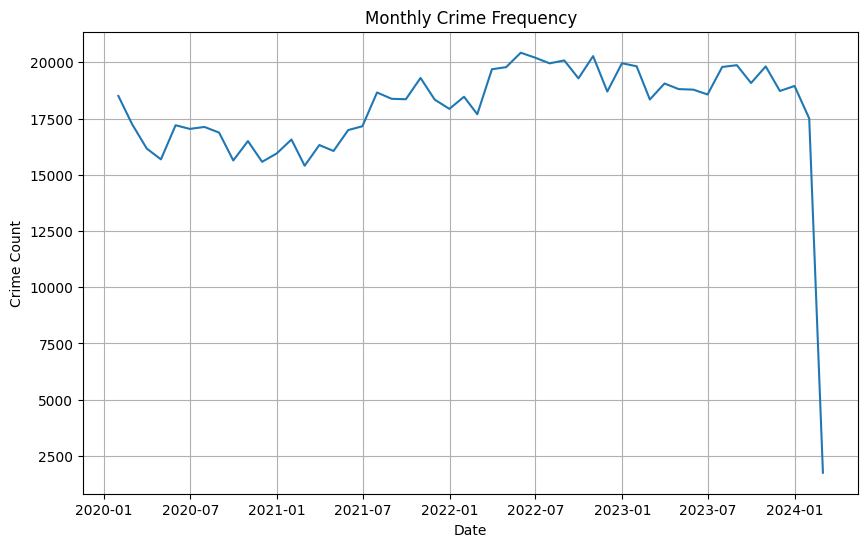

In [64]:
la_df['DATE OCC'] = pd.to_datetime(la_df['DATE OCC'], format='%m-%d-%Y')
la_df.set_index('DATE OCC', inplace=True)
time_series = la_df.resample('M').size()

# 1. Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series)
plt.title('Monthly Crime Frequency')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.grid()
plt.show()

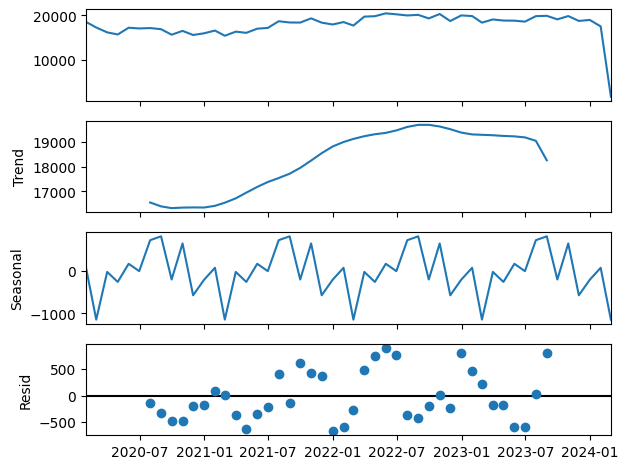

In [65]:
# 2. Decompose time series to see trend, seasonality, and residuals
decomposition = seasonal_decompose(time_series, model='additive')
decomposition.plot()
plt.show()


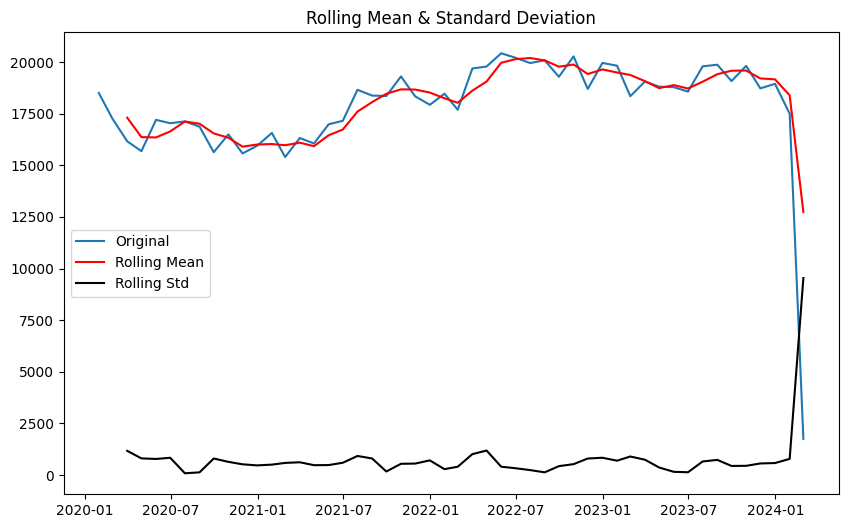

In [66]:
# 3. Rolling mean and standard deviation
rolling_mean = time_series.rolling(window=3).mean()
rolling_std = time_series.rolling(window=3).std()

plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

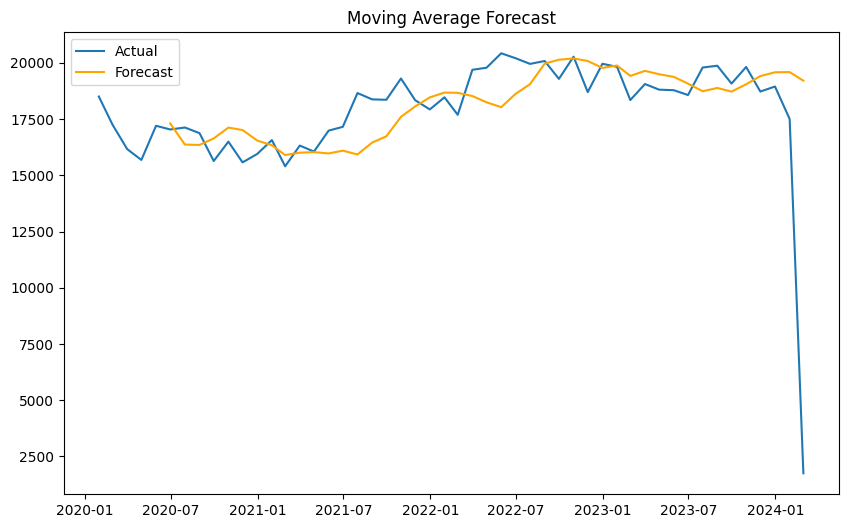

In [67]:
# 4. Simple moving average forecasting
forecast_period = 3
time_series_shift = time_series.shift(forecast_period)
time_series_ma_forecast = time_series_shift.rolling(window=3).mean()

plt.figure(figsize=(10, 6))
plt.plot(time_series, label='Actual')
plt.plot(time_series_ma_forecast, color='orange', label='Forecast')
plt.legend()
plt.title('Moving Average Forecast')
plt.show()


**Geospatial Analysis**

In [68]:
# Group by Zone and calculate the mean severity
zone_group = la_df.groupby('Zone').agg({
    'LAT': 'mean',
    'LON': 'mean',
    'Severity_Crime': 'mean'
}).reset_index()

# Prepare GeoDataFrame
zone_gdf = gpd.GeoDataFrame(
    zone_group,
    geometry=gpd.points_from_xy(zone_group['LON'], zone_group['LAT'])
)

# Set up a folium map
map_center = [la_df['LAT'].mean(), la_df['LON'].mean()]
zone_map = folium.Map(location=map_center, zoom_start=12)

# Add markers to the map based on severity
for _, row in zone_gdf.iterrows():
    folium.CircleMarker(
        location=[row['LAT'], row['LON']],
        radius=10,
        popup=(f"Zone: {row['Zone']}<br>"
               f"Avg Severity: {row['Severity_Crime']:.2f}"),
        color='crimson',
        fill=True,
        fill_color='crimson'
    ).add_to(zone_map)

zone_map.save("zone_crime_severity_map.html")
zone_map

In [69]:
area_severity = la_df.groupby('AREA NAME')['Severity_Crime'].agg(['mean', 'sum'])

print("Crime Severity by Area:")
print(area_severity.sort_values(by='mean', ascending=False))

Crime Severity by Area:
                 mean     sum
AREA NAME                    
77th Street  8.237210  460180
Southeast    8.223958  371065
Newton       8.020840  356775
Rampart      7.936648  334744
Southwest    7.901445  395815
Hollenbeck   7.875420  262346
Olympic      7.834816  353264
Harbor       7.832562  287831
Central      7.828224  475956
Mission      7.757524  275555
Hollywood    7.739828  363888
Foothill     7.720316  227896
West Valley  7.615286  285657
Topanga      7.577447  276251
Van Nuys     7.577093  285520
Northeast    7.538247  289627
Devonshire   7.526617  273585
Wilshire     7.526276  321515
N Hollywood  7.520264  335855
Pacific      7.429553  386099
West LA      7.301441  298461


In [70]:
area_severity = la_df.groupby('AREA NAME')['Severity_Crime'].agg(['mean', 'sum'])
area_severity.columns = ['Average Severity', 'Total Severity']
sorted_area_severity = area_severity.sort_values(by='Average Severity')

# Display the areas with the lowest severity (best to live)
best_area = sorted_area_severity.head(1)
print("Best area to live based on lowest severity level:")
print(best_area)

# Display the areas with the highest severity
worst_area = sorted_area_severity.tail(1)
print("\nArea with the highest severity level:")
print(worst_area)

# Optionally: List a few more best areas to give more options
best_areas = sorted_area_severity.head(3)
print("\nTop 3 best areas to live based on severity level:")
print(best_areas)


Best area to live based on lowest severity level:
           Average Severity  Total Severity
AREA NAME                                  
West LA            7.301441          298461

Area with the highest severity level:
             Average Severity  Total Severity
AREA NAME                                    
77th Street           8.23721          460180

Top 3 best areas to live based on severity level:
             Average Severity  Total Severity
AREA NAME                                    
West LA              7.301441          298461
Pacific              7.429553          386099
N Hollywood          7.520264          335855


In [71]:
future_data

,DATE OCC,AREA NAME,Vict Age,Vict Sex,Weapon Desc,LAT,LON,Hour,Crime Description,Severity_Crime,Zone
0,03-01-2020,Wilshire,0,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0375,-118.3506,21,Property Crimes,7,zone5
1,02-08-2020,Central,47,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0444,-118.2628,18,Property Crimes,7,zone3
2,11-04-2020,Southwest,19,X,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0210,-118.3002,17,Property Crimes,7,zone3
3,03-10-2020,Van Nuys,19,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.1576,-118.4387,20,Property Crimes,7,zone1
4,08-17-2020,Hollywood,28,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0944,-118.3277,12,Property Crimes,7,zone5
...,...,...,...,...,...,...,...,...,...,...,...
892381,01-13-2024,Foothill,36,M,OTHER KNIFE,34.2271,-118.3878,7,Violent Crimes,10,zone1
892382,01-08-2024,Foothill,42,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.2865,-118.4161,8,Non-Violent Miscellaneous,3,zone1
892383,01-16-2024,Olympic,80,F,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0690,-118.3054,15,Violent Crimes,10,zone5
892384,01-31-2024,Wilshire,0,M,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",34.0360,-118.3527,0,Property Crimes,7,zone5


In [92]:
start_date = pd.to_datetime('2024-06-01')
end_date = pd.to_datetime('2024-12-31')
dates = pd.date_range(start=start_date, end=end_date)

num_records = 100000  # Number of synthetic records to generate
filtered_data = future_data[(future_data['LAT'] != 0) & (future_data['LON'] != 0)]

# Precompute unique values and probabilities
area_names = future_data['AREA NAME'].dropna().unique()
crime_descriptions = future_data['Crime Description'].dropna().unique()
weapon_descriptions = future_data['Weapon Desc'].dropna().unique()
weapon_probs = future_data['Weapon Desc'].value_counts(normalize=True).reindex(weapon_descriptions, fill_value=0).values

zones = future_data['Zone'].dropna().unique()
hour = future_data['Hour'].dropna().unique()
lat_min, lat_max = filtered_data['LAT'].min(), filtered_data['LAT'].max()
lon_min, lon_max = filtered_data['LON'].min(), filtered_data['LON'].max()

# Generate data using numpy's vectorized functions
synthetic_data = {
    'DATE OCC': np.random.choice(dates, size=num_records),
    'AREA NAME': np.random.choice(area_names, size=num_records),
    'Crime Description': np.random.choice(crime_descriptions, size=num_records),
    'Weapon Desc': np.random.choice(weapon_descriptions, p=weapon_probs, size=num_records),

    'Zone': np.random.choice(zones, size=num_records),
    'Hour': np.random.choice(hour, size=num_records),
    'LAT': np.random.uniform(lat_min, lat_max, size=num_records),
    'LON': np.random.uniform(lon_min, lon_max, size=num_records)
}

synthetic_df = pd.DataFrame(synthetic_data)

synthetic_df = synthetic_df.drop(columns=["Zone"])




synthetic_df

,DATE OCC,AREA NAME,Crime Description,Weapon Desc,Hour,LAT,LON
0,2024-06-23,Van Nuys,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",4,33.773490,-118.647663
1,2024-11-18,Devonshire,Drug/Alcohol Related,HAND GUN,1,33.763685,-118.466229
2,2024-07-28,Hollywood,Violent Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",2,33.980548,-118.372111
3,2024-06-12,West Valley,Domestic Violence,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",10,34.119342,-118.178178
4,2024-11-16,Pacific,Traffic Violations,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",1,34.103015,-118.403806
...,...,...,...,...,...,...,...
99995,2024-11-09,Pacific,Domestic Violence,UNKNOWN WEAPON/OTHER WEAPON,23,33.764192,-118.239972
99996,2024-12-31,Harbor,Drug/Alcohol Related,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",20,34.068371,-118.397257
99997,2024-09-23,Southeast,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",3,34.121705,-118.237858
99998,2024-09-23,Hollywood,Domestic Violence,STICK,16,33.863821,-118.203804


In [94]:
# Convert Timestamp column to Unix timestamp (numeric)
synthetic_df['timestamp_numeric'] = synthetic_df['DATE OCC'].astype(int) // 10**9
# Fit KMeans model
kmeans = KMeans(n_clusters=5, random_state=0)
model = kmeans.fit(synthetic_df[['timestamp_numeric']])

# Add cluster labels to the DataFrame
synthetic_df['Cluster'] = model.labels_

# Create a mapping from cluster labels to zones
zone_mapping = {0: 'zone1', 1: 'zone2', 2: 'zone3', 3: 'zone4', 4: 'zone5'}

def map_cluster_to_zone(cluster):
    return zone_mapping.get(cluster, "Unknown")

# Apply the mapping function to create the "Zone" column
synthetic_df['Zone'] = synthetic_df['Cluster'].apply(map_cluster_to_zone)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [96]:
synthetic_df

,DATE OCC,AREA NAME,Crime Description,Weapon Desc,Hour,LAT,LON,timestamp_numeric,Cluster,Zone
0,2024-06-23,Van Nuys,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",4,33.773490,-118.647663,1719100800,1,zone2
1,2024-11-18,Devonshire,Drug/Alcohol Related,HAND GUN,1,33.763685,-118.466229,1731888000,4,zone5
2,2024-07-28,Hollywood,Violent Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",2,33.980548,-118.372111,1722124800,3,zone4
3,2024-06-12,West Valley,Domestic Violence,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",10,34.119342,-118.178178,1718150400,1,zone2
4,2024-11-16,Pacific,Traffic Violations,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",1,34.103015,-118.403806,1731715200,4,zone5
...,...,...,...,...,...,...,...,...,...,...
99995,2024-11-09,Pacific,Domestic Violence,UNKNOWN WEAPON/OTHER WEAPON,23,33.764192,-118.239972,1731110400,4,zone5
99996,2024-12-31,Harbor,Drug/Alcohol Related,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",20,34.068371,-118.397257,1735603200,0,zone1
99997,2024-09-23,Southeast,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",3,34.121705,-118.237858,1727049600,2,zone3
99998,2024-09-23,Hollywood,Domestic Violence,STICK,16,33.863821,-118.203804,1727049600,2,zone3


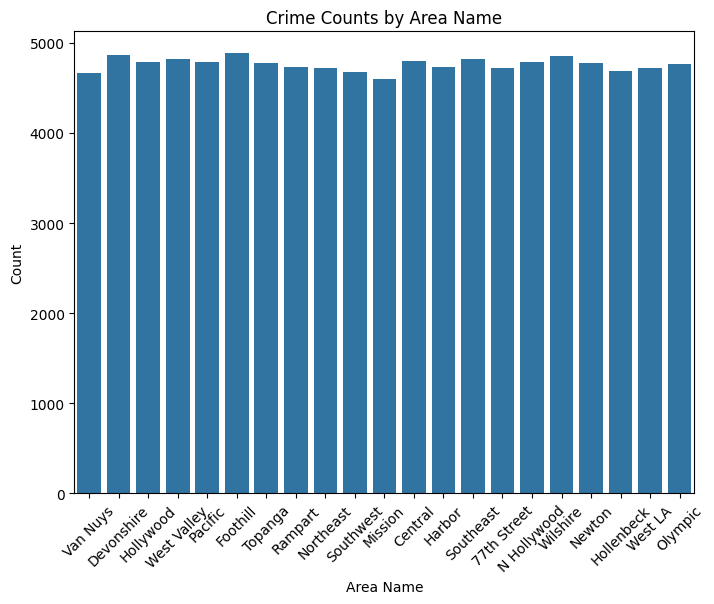

In [97]:
plt.figure(figsize=(8, 6))
sns.countplot(data=synthetic_df, x='AREA NAME')
plt.title('Crime Counts by Area Name')
plt.xlabel('Area Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


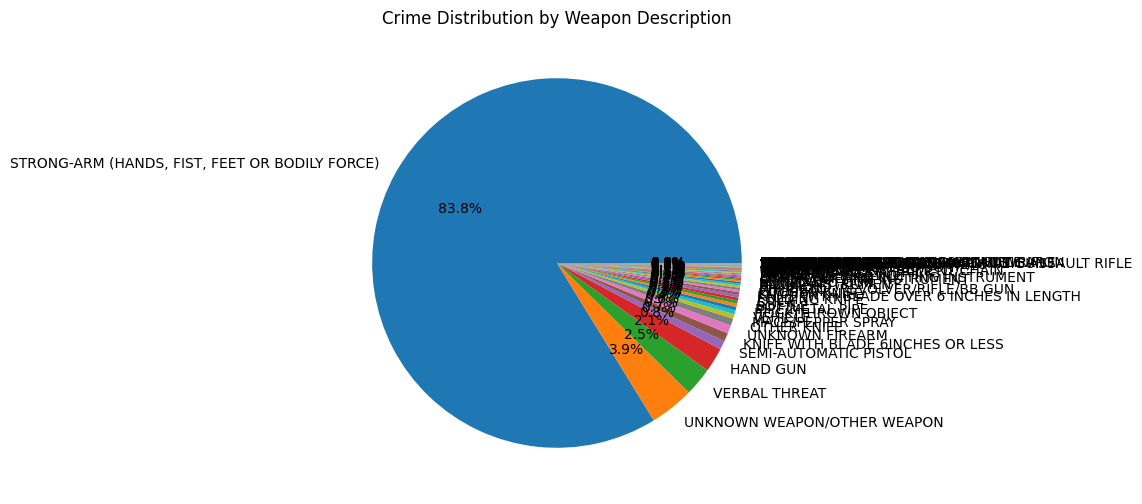

In [98]:
plt.figure(figsize=(8, 6))
synthetic_df['Weapon Desc'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Crime Distribution by Weapon Description')
plt.ylabel('')
plt.show()

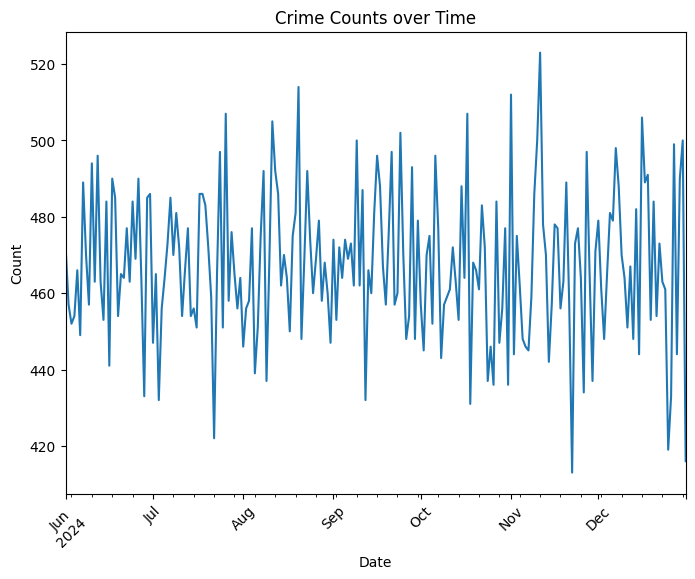

In [99]:
# Visualization 4: Line chart of Crime Counts over Time (Date Occ)
plt.figure(figsize=(8, 6))
synthetic_df['DATE OCC'] = pd.to_datetime(synthetic_df['DATE OCC'])
synthetic_df['DATE OCC'].value_counts().sort_index().plot(kind='line')
plt.title('Crime Counts over Time')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

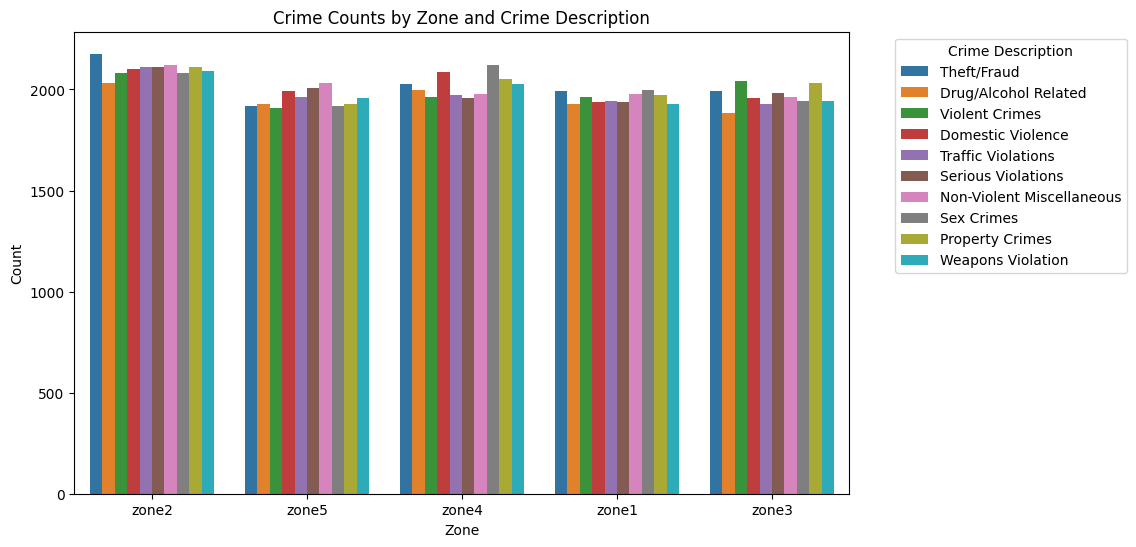

In [100]:
# Visualization 7: Stacked bar chart of Crime Counts by Zone and Crime Description
plt.figure(figsize=(10, 6))
sns.countplot(data=synthetic_df, x='Zone', hue='Crime Description')
plt.title('Crime Counts by Zone and Crime Description')
plt.xlabel('Zone')
plt.ylabel('Count')
plt.legend(title='Crime Description', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

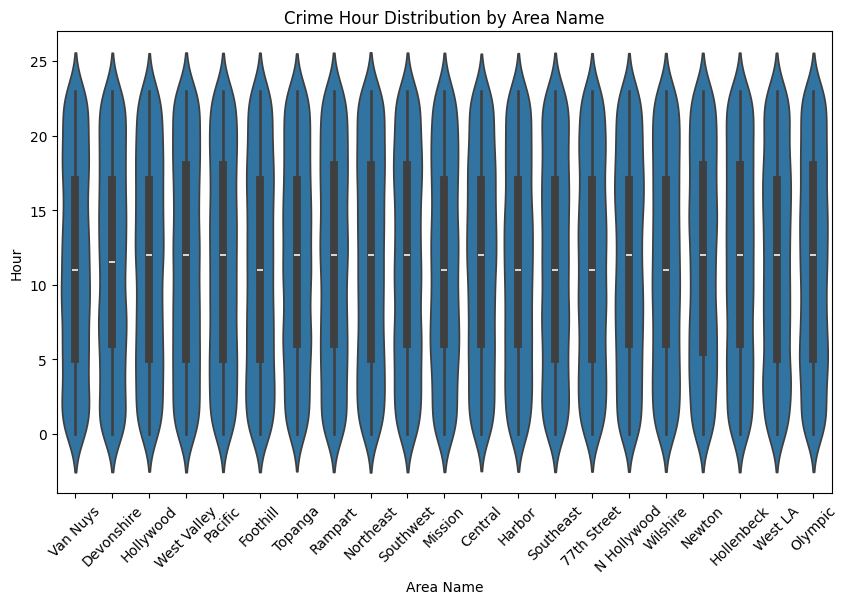

In [101]:
# Visualization 9: Violin plot of Crime Hour Distribution by Area Name
plt.figure(figsize=(10, 6))
sns.violinplot(data=synthetic_df, x='AREA NAME', y='Hour')
plt.title('Crime Hour Distribution by Area Name')
plt.xlabel('Area Name')
plt.ylabel('Hour')
plt.xticks(rotation=45)
plt.show()


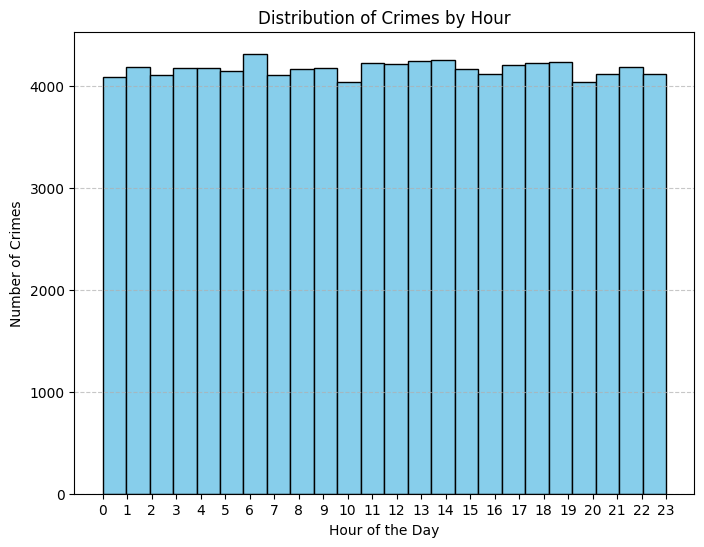

In [102]:
plt.figure(figsize=(8, 6))
plt.hist(synthetic_df['Hour'], bins=24, color='skyblue', edgecolor='black')
plt.title('Distribution of Crimes by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Crimes')
plt.xticks(range(24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [103]:
synthetic_df

,DATE OCC,AREA NAME,Crime Description,Weapon Desc,Hour,LAT,LON,timestamp_numeric,Cluster,Zone
0,2024-06-23,Van Nuys,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",4,33.773490,-118.647663,1719100800,1,zone2
1,2024-11-18,Devonshire,Drug/Alcohol Related,HAND GUN,1,33.763685,-118.466229,1731888000,4,zone5
2,2024-07-28,Hollywood,Violent Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",2,33.980548,-118.372111,1722124800,3,zone4
3,2024-06-12,West Valley,Domestic Violence,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",10,34.119342,-118.178178,1718150400,1,zone2
4,2024-11-16,Pacific,Traffic Violations,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",1,34.103015,-118.403806,1731715200,4,zone5
...,...,...,...,...,...,...,...,...,...,...
99995,2024-11-09,Pacific,Domestic Violence,UNKNOWN WEAPON/OTHER WEAPON,23,33.764192,-118.239972,1731110400,4,zone5
99996,2024-12-31,Harbor,Drug/Alcohol Related,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",20,34.068371,-118.397257,1735603200,0,zone1
99997,2024-09-23,Southeast,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",3,34.121705,-118.237858,1727049600,2,zone3
99998,2024-09-23,Hollywood,Domestic Violence,STICK,16,33.863821,-118.203804,1727049600,2,zone3


In [104]:
df_zone1 = synthetic_df[synthetic_df['Zone'] == 'zone1']
df_zone2 = synthetic_df[synthetic_df['Zone'] == 'zone2']
df_zone3 = synthetic_df[synthetic_df['Zone'] == 'zone3']
df_zone4 = synthetic_df[synthetic_df['Zone'] == 'zone4']
df_zone5 = synthetic_df[synthetic_df['Zone'] == 'zone5']

In [105]:
df_zone3 = synthetic_df[synthetic_df['Zone'] == 'zone3']

df_zone3

,DATE OCC,AREA NAME,Crime Description,Weapon Desc,Hour,LAT,LON,timestamp_numeric,Cluster,Zone
11,2024-10-07,Northeast,Sex Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",16,34.220767,-118.155757,1728259200,2,zone3
12,2024-10-05,Topanga,Traffic Violations,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",21,34.271853,-118.266423,1728086400,2,zone3
13,2024-09-08,Topanga,Drug/Alcohol Related,VERBAL THREAT,22,34.259960,-118.293042,1725753600,2,zone3
17,2024-09-29,Harbor,Sex Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",10,34.056194,-118.487121,1727568000,2,zone3
24,2024-10-04,Wilshire,Sex Crimes,PIPE/METAL PIPE,19,34.054295,-118.434999,1728000000,2,zone3
...,...,...,...,...,...,...,...,...,...,...
99986,2024-10-04,Southeast,Violent Crimes,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",4,34.197278,-118.416310,1728000000,2,zone3
99990,2024-09-23,West LA,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",9,33.842697,-118.376632,1727049600,2,zone3
99991,2024-09-08,Hollenbeck,Drug/Alcohol Related,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",8,34.014455,-118.500080,1725753600,2,zone3
99997,2024-09-23,Southeast,Theft/Fraud,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",3,34.121705,-118.237858,1727049600,2,zone3


In [106]:
sampled_data = df_zone1.sample(frac=0.1, replace=False)
sampled_data['LAT'] = pd.to_numeric(sampled_data['LAT'], errors='coerce')
sampled_data['LON'] = pd.to_numeric(sampled_data['LON'], errors='coerce')
sampled_data.dropna(subset=['LAT', 'LON'], inplace=True)

map_la = folium.Map(location=[sampled_data['LAT'].mean(), sampled_data['LON'].mean()], zoom_start=11)
HeatMap(data=sampled_data[['LAT', 'LON']].values, radius=10).add_to(map_la)

map_la